# PredictaMed
## Multi Disease Classification Using Machine Learning
## Developed by: Zayyan

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Proccess Data - EDA

## Encodding Features

In [2]:
data = pd.read_csv('Multiple Disease Data.csv')
encode = {'Smoking': {'Yes': 1, 'No': 0},'AlcoholDrinking': {'Yes': 1, 'No': 0},
    'Stroke': {'Yes': 1, 'No': 0},'DiffWalking': {'Yes': 1, 'No': 0},'Sex': {'Male': 1, 'Female': 0},
    'AgeCategory': {'18-24': 0, '25-29': 1, '30-34': 2, '35-39': 3, '40-44': 4, '45-49': 5, '50-54': 6, '55-59': 7, '60-64': 8, 
                    '65-69': 9, '70-74': 10, '75-79': 11, '80 or older': 12},
    'Race': {'White': 0, 'Black': 1, 'Asian': 2, 'Hispanic': 3, 'Other': 4},
    'PhysicalActivity': {'Yes': 1, 'No': 0},'GenHealth': {'Poor': 0, 'Fair': 1, 'Good': 2, 'Very good': 3, 'Excellent': 4},
    'HeartDisease' : {'Yes': 1, 'No': 0}, 'Stroke' : {'Yes': 1, 'No': 0},'Diabetic' : {'Yes': 1, 'No': 0}, 'Asthma' : {'Yes': 1, 'No': 0}, 
    'KidneyDisease' : {'Yes': 1, 'No': 0},'SkinCancer' : {'Yes': 1, 'No': 0}}

for column, encodeDict in encode.items():
    data[column] = data[column].map(encodeDict)

print("dataset info:")
data.info()
print("\nsummary statistics:")
print(data.describe())

dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59068 entries, 0 to 59067
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   HeartDisease      59068 non-null  int64  
 1   BMI               59068 non-null  float64
 2   Smoking           59068 non-null  int64  
 3   AlcoholDrinking   59068 non-null  int64  
 4   Stroke            59068 non-null  int64  
 5   PhysicalHealth    59068 non-null  int64  
 6   MentalHealth      59040 non-null  float64
 7   DiffWalking       59068 non-null  int64  
 8   Sex               59068 non-null  int64  
 9   AgeCategory       59068 non-null  int64  
 10  Race              57533 non-null  float64
 11  Diabetic          57237 non-null  float64
 12  PhysicalActivity  59068 non-null  int64  
 13  GenHealth         59059 non-null  float64
 14  SleepTime         59068 non-null  int64  
 15  Asthma            59068 non-null  int64  
 16  KidneyDisease     59068 no

## Visualizing

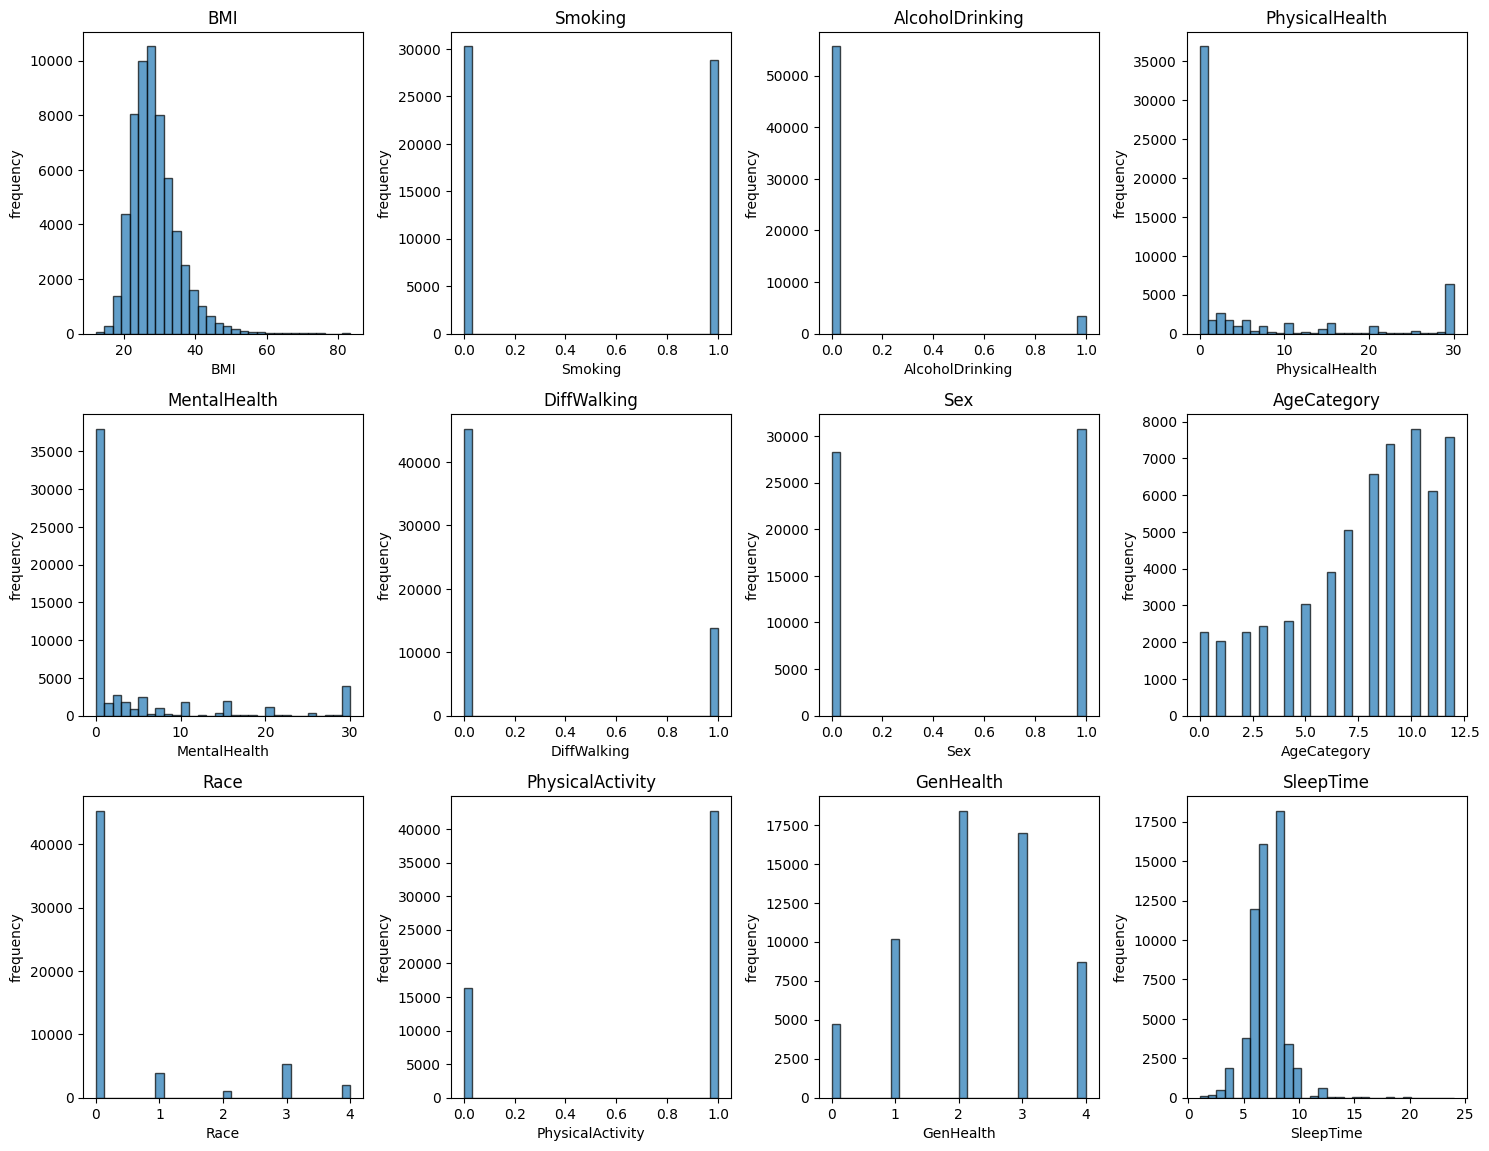

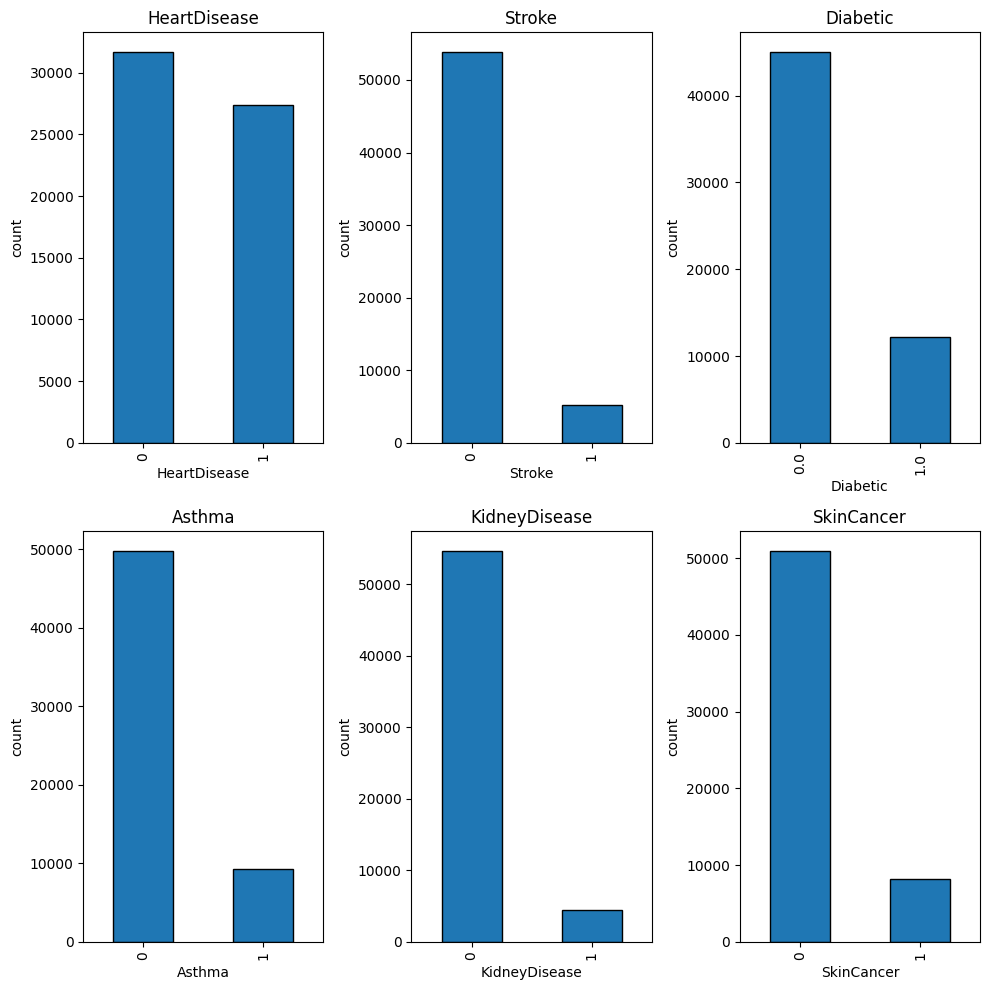

In [12]:
feature = ['BMI', 'Smoking', 'AlcoholDrinking', 'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory', 'Race', 'PhysicalActivity', 'GenHealth', 'SleepTime']
plt.figure(figsize=(15, 15))
for i, feature in enumerate(feature):
    plt.subplot(4, 4, i + 1)
    data[feature].plot(kind='hist', bins=30, edgecolor='black', alpha=0.7)
    plt.title(feature)
    plt.xlabel(feature)
    plt.ylabel('frequency')
plt.tight_layout()
plt.show()

target = ['HeartDisease', 'Stroke', 'Diabetic', 'Asthma', 'KidneyDisease', 'SkinCancer']
plt.figure(figsize=(10, 10))
for i, target in enumerate(target):
    plt.subplot(2, 3, i + 1)
    data[target].value_counts().plot(kind='bar', edgecolor='black')
    plt.title(target)
    plt.xlabel(target)
    plt.ylabel('count')
plt.tight_layout()
plt.show()

# Compute Correlation

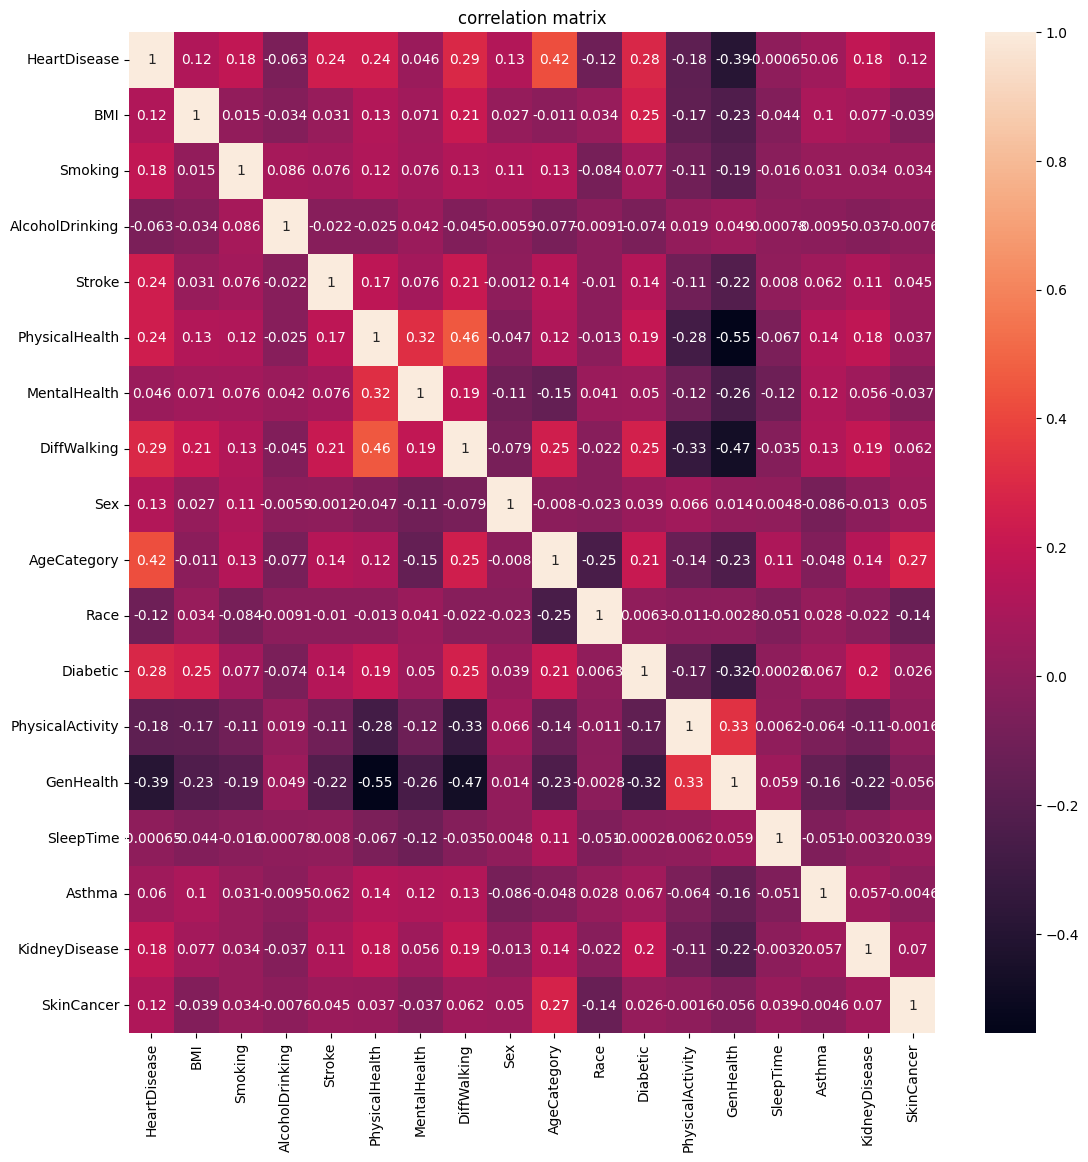

correlation with HeartDisease:
HeartDisease        1.000000
AgeCategory         0.423665
DiffWalking         0.292551
Diabetic            0.284104
PhysicalHealth      0.238557
Stroke              0.237228
KidneyDisease       0.183720
Smoking             0.182721
Sex                 0.126838
BMI                 0.120264
SkinCancer          0.119374
Asthma              0.059514
MentalHealth        0.046395
SleepTime          -0.000654
AlcoholDrinking    -0.062526
Race               -0.116672
PhysicalActivity   -0.175646
GenHealth          -0.393492
Name: HeartDisease, dtype: float64


correlation with Stroke:
Stroke              1.000000
HeartDisease        0.237228
DiffWalking         0.209619
PhysicalHealth      0.172270
AgeCategory         0.139046
Diabetic            0.137317
KidneyDisease       0.108515
MentalHealth        0.076402
Smoking             0.076272
Asthma              0.062127
SkinCancer          0.045306
BMI                 0.031247
SleepTime           0.007997
Sex     

In [3]:
matrix = data.corr()
target = ['HeartDisease', 'Stroke', 'Diabetic', 'Asthma', 'KidneyDisease', 'SkinCancer']

plt.figure(figsize=(13, 13))
sns.heatmap(matrix, annot=True)
plt.title("correlation matrix")
plt.show()

for i in target:
    corr = matrix[i].sort_values(ascending=False)
    print(f"correlation with {i}:")
    print(corr)
    print("\n")

# Define and Set Threshold

In [4]:
threshold = {'HeartDisease': 0.2, 'Stroke': 0.13, 'Diabetic': 0.2, 'Asthma': 0.1, 'KidneyDisease': 0.13, 'SkinCancer': 0.06}
greater = {}

for condition, thresh in threshold.items():
    corrTarget = matrix[condition]
    greater[condition] = corrTarget[corrTarget > thresh].index.tolist()

for condition, features in greater.items():
    print(f"Features with correlation > {threshold[condition]} for {condition}:")
    print(features)
    print("\n")

Features with correlation > 0.2 for HeartDisease:
['HeartDisease', 'Stroke', 'PhysicalHealth', 'DiffWalking', 'AgeCategory', 'Diabetic']


Features with correlation > 0.13 for Stroke:
['HeartDisease', 'Stroke', 'PhysicalHealth', 'DiffWalking', 'AgeCategory', 'Diabetic']


Features with correlation > 0.2 for Diabetic:
['HeartDisease', 'BMI', 'DiffWalking', 'AgeCategory', 'Diabetic']


Features with correlation > 0.1 for Asthma:
['BMI', 'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Asthma']


Features with correlation > 0.13 for KidneyDisease:
['HeartDisease', 'PhysicalHealth', 'DiffWalking', 'AgeCategory', 'Diabetic', 'KidneyDisease']


Features with correlation > 0.06 for SkinCancer:
['HeartDisease', 'DiffWalking', 'AgeCategory', 'KidneyDisease', 'SkinCancer']




# Define Target and Related Dictionaries

In [5]:
target = ['HeartDisease', 'Stroke', 'Diabetic', 'Asthma', 'KidneyDisease', 'SkinCancer']
resultLog = {}
resultNaive = {}
resultDes = {}
resultRandom = {}
resultknn = {}
resultsvm = {}
pd.set_option('display.max_colwidth', None)

# Train Model Using Logistic Regression 

In [6]:
hyperpara = {'C': [0.1, 1, 10], 'solver': ['liblinear', 'lbfgs'], 'max_iter': [100, 300, 500]}

for i in target:
    selectFeat = greater.get(i, [])
    dataset = data.dropna()
    x = dataset[selectFeat]
    y = dataset[i]
    x = x.drop(i, axis=1)
    
    imputer = SimpleImputer(strategy='mean')
    xImpute = imputer.fit_transform(x)
    scaler = StandardScaler()
    xScaled = scaler.fit_transform(xImpute)
    
    xtrain, xvt, ytrain, yvt = train_test_split(xScaled, y, test_size=0.4, random_state=42)
    xval, xtest, yval, ytest = train_test_split(xvt, yvt, test_size=0.5, random_state=42)
    
    logReg = LogisticRegression()
    grid = GridSearchCV(estimator=logReg, param_grid=hyperpara, cv=5, scoring='accuracy', verbose=0)
    grid.fit(xtrain, ytrain)
    
    best = grid.best_estimator_
    ytrainp = best.predict(xtrain)
    yvalp = best.predict(xval)
    ytestp = best.predict(xtest)
    trainacc = accuracy_score(ytrain, ytrainp)
    valacc = accuracy_score(yval, yvalp)
    testacc = accuracy_score(ytest, ytestp)
    
    ytrainprob = best.predict_proba(xtrain)[:, 1]
    yvalprob = best.predict_proba(xval)[:, 1]
    ytestprob = best.predict_proba(xtest)[:, 1]
    trainauc = roc_auc_score(ytrain, ytrainprob)
    valauc = roc_auc_score(yval, yvalprob)
    testauc = roc_auc_score(ytest, ytestprob)
    resultLog[i] = {'best parameters': grid.best_params_,'train accuracy': trainacc,'validation accuracy': valacc,'test accuracy': testacc,'train auc': trainauc,'validation auc': valauc,'test auc': testauc}

result = pd.DataFrame(resultLog).T
print(result)

                                                  best parameters  \
HeartDisease     {'C': 1, 'max_iter': 100, 'solver': 'liblinear'}   
Stroke         {'C': 0.1, 'max_iter': 100, 'solver': 'liblinear'}   
Diabetic        {'C': 10, 'max_iter': 100, 'solver': 'liblinear'}   
Asthma         {'C': 0.1, 'max_iter': 100, 'solver': 'liblinear'}   
KidneyDisease  {'C': 0.1, 'max_iter': 100, 'solver': 'liblinear'}   
SkinCancer     {'C': 0.1, 'max_iter': 100, 'solver': 'liblinear'}   

              train accuracy validation accuracy test accuracy train auc  \
HeartDisease        0.724992            0.725218      0.723154  0.805453   
Stroke              0.913245            0.912981      0.911277  0.781491   
Diabetic            0.790933            0.800126      0.800395  0.774753   
Asthma              0.844104            0.843097      0.850274   0.63649   
KidneyDisease       0.925656            0.926976      0.924105  0.779749   
SkinCancer          0.859117            0.856284      0.8648

# Train Model Using Naive Bayes Classifier

In [7]:
for i in target:
    selectFeat = greater.get(i, [])
    dataset = data.dropna()
    x = dataset[selectFeat]
    y = dataset[i]
    x = x.drop(i, axis=1)
    
    imputer = SimpleImputer(strategy='mean')
    xImpute = imputer.fit_transform(x)   
    scaler = StandardScaler()
    xScaled = scaler.fit_transform(xImpute)
    
    xtrain, xvt, ytrain, yvt = train_test_split(xScaled, y, test_size=0.4, random_state=42)
    xval, xtest, yval, ytest = train_test_split(xvt, yvt, test_size=0.5, random_state=42)
    
    naiveBayes = GaussianNB()
    grid = GridSearchCV(estimator=naiveBayes, param_grid={'var_smoothing': [1e-9, 1e-8, 1e-7]}, cv=5, scoring='accuracy', verbose=0)
    grid.fit(xtrain, ytrain)
    
    best = grid.best_estimator_
    ytrainp = best.predict(xtrain)
    yvalp = best.predict(xval)
    ytestp = best.predict(xtest)
    
    trainacc = accuracy_score(ytrain, ytrainp)
    valacc = accuracy_score(yval, yvalp)
    testacc = accuracy_score(ytest, ytestp)
    
    ytrainprob = best.predict_proba(xtrain)[:, 1]
    yvalprob = best.predict_proba(xval)[:, 1]
    ytestprob = best.predict_proba(xtest)[:, 1]
    trainauc = roc_auc_score(ytrain, ytrainprob)
    valauc = roc_auc_score(yval, yvalprob)
    testauc = roc_auc_score(ytest, ytestprob)
    resultNaive[i] = {'best parameters': grid.best_params_, 'train accuracy': trainacc, 'validation accuracy': valacc, 'test accuracy': testacc, 'train auc': trainauc, 'validation auc': valauc, 'test auc': testauc}

result = pd.DataFrame(resultNaive).T
print(result)

                        best parameters train accuracy validation accuracy  \
HeartDisease   {'var_smoothing': 1e-09}        0.70965            0.707993   
Stroke         {'var_smoothing': 1e-09}       0.840605            0.846954   
Diabetic       {'var_smoothing': 1e-09}       0.768354            0.772764   
Asthma         {'var_smoothing': 1e-09}        0.78872            0.789899   
KidneyDisease  {'var_smoothing': 1e-09}       0.861479            0.858527   
SkinCancer     {'var_smoothing': 1e-09}       0.824277            0.825783   

              test accuracy train auc validation auc  test auc  
HeartDisease       0.711133  0.800119       0.799798   0.80076  
Stroke             0.844801  0.777056       0.781559    0.7709  
Diabetic            0.77411  0.773274       0.766404  0.773651  
Asthma             0.795371  0.636412        0.63246  0.629679  
KidneyDisease      0.864717  0.775609          0.777  0.784546  
SkinCancer         0.827756  0.706754       0.718487  0.708312 

# Train Model Using Descion Trees

In [8]:
hyperpara = {'max_depth': [3, 5, 10], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2, 5], 'criterion': ['gini', 'entropy']}

for i in target:
    selectFeat = greater.get(i, [])
    dataset = data.dropna()
    x = dataset[selectFeat]
    y = dataset[i]
    x = x.drop(i, axis=1)

    imputer = SimpleImputer(strategy='mean')
    xImpute = imputer.fit_transform(x)
    scaler = StandardScaler()
    xScaled = scaler.fit_transform(xImpute)
    
    xtrain, xvt, ytrain, yvt = train_test_split(xScaled, y, test_size=0.4, random_state=42)
    xval, xtest, yval, ytest = train_test_split(xvt, yvt, test_size=0.5, random_state=42)
    dt = DecisionTreeClassifier(random_state=42)
    grid = GridSearchCV(estimator=dt, param_grid=hyperpara, cv=5, scoring='accuracy', verbose=0)
    grid.fit(xtrain, ytrain)
    
    best = grid.best_estimator_
    ytrainp = best.predict(xtrain)
    yvalp = best.predict(xval)
    ytestp = best.predict(xtest)

    trainacc = accuracy_score(ytrain, ytrainp)
    valacc = accuracy_score(yval, yvalp)
    testacc = accuracy_score(ytest, ytestp)
    
    ytrainprob = best.predict_proba(xtrain)[:, 1]
    yvalprob = best.predict_proba(xval)[:, 1]
    ytestprob = best.predict_proba(xtest)[:, 1]
    trainauc = roc_auc_score(ytrain, ytrainprob)
    valauc = roc_auc_score(yval, yvalprob)
    testauc = roc_auc_score(ytest, ytestprob)
    resultDes[i] = {'best parameters': grid.best_params_, 'train accuracy': trainacc, 'validation accuracy': valacc, 'test accuracy': testacc, 'train auc': trainauc, 'validation auc': valauc, 'test auc': testauc}

result = pd.DataFrame(resultDes).T
print(result)

                                                                                       best parameters  \
HeartDisease     {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2}   
Stroke            {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}   
Diabetic       {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}   
Asthma            {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}   
KidneyDisease  {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}   
SkinCancer        {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}   

              train accuracy validation accuracy test accuracy train auc  \
HeartDisease        0.731631             0.72145       0.72136   0.81383   
Stroke              0.913305            0.912981      0.911366  0.786075   
Diabetic            0.794372 

# Train Model Using Random Forest

In [9]:
for i in target:
    selectFeat = greater.get(i, [])
    dataset = data.dropna()
    x = dataset[selectFeat]
    y = dataset[i]
    x = x.drop(i, axis=1)
    scaler = StandardScaler()
    xScaled = scaler.fit_transform(x)
    xtrain, xvt, ytrain, yvt = train_test_split(xScaled, y, test_size=0.4, random_state=42)
    xval, xtest, yval, ytest = train_test_split(xvt, yvt, test_size=0.5, random_state=42)
    
    grid = GridSearchCV(
        estimator=RandomForestClassifier(random_state=42),
        param_grid={'n_estimators': [50, 100], 'max_depth': [3, 5], 'criterion': ['gini', 'entropy'], 'bootstrap': [True, False]},cv=2, scoring='accuracy', verbose=0 ,n_jobs=-1)
    grid.fit(xtrain, ytrain)
    
    best = grid.best_estimator_
    ytrainp = best.predict(xtrain)
    yvalp = best.predict(xval)
    ytestp = best.predict(xtest)
    
    trainacc = accuracy_score(ytrain, ytrainp)
    valacc = accuracy_score(yval, yvalp)
    testacc = accuracy_score(ytest, ytestp)
    ytrainprob = best.predict_proba(xtrain)[:, 1]
    yvalprob = best.predict_proba(xval)[:, 1]
    ytestprob = best.predict_proba(xtest)[:, 1]
    trainauc = roc_auc_score(ytrain, ytrainprob)
    valauc = roc_auc_score(yval, yvalprob)
    testauc = roc_auc_score(ytest, ytestprob)
    resultRandom[i] = {'best parameters': grid.best_params_, 'train accuracy': trainacc, 'validation accuracy': valacc, 'test accuracy': testacc, 'train auc': trainauc, 'validation auc': valauc, 'test auc': testauc}

result = pd.DataFrame(resultRandom).T
print(result)

                                                                               best parameters  \
HeartDisease     {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'n_estimators': 100}   
Stroke           {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'n_estimators': 50}   
Diabetic       {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 50}   
Asthma           {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'n_estimators': 100}   
KidneyDisease     {'bootstrap': True, 'criterion': 'gini', 'max_depth': 3, 'n_estimators': 50}   
SkinCancer        {'bootstrap': True, 'criterion': 'gini', 'max_depth': 3, 'n_estimators': 50}   

              train accuracy validation accuracy test accuracy train auc  \
HeartDisease        0.728162            0.727371      0.729793  0.806699   
Stroke              0.913275            0.912981      0.911277  0.788373   
Diabetic            0.795658            0.804252      0.803893  0.785984   
Asthma   

# Train Model Using K-Nearest Neighbour

In [10]:
hyperpara = {'n_neighbors': [3, 5, 7], 'metric': ['euclidean', 'manhattan']}

for i in target:
    selectFeat = greater.get(i, [])
    dataset = data.dropna()
    x = dataset[selectFeat]
    y = dataset[i]
    x = x.drop(i, axis=1)
    scaler = StandardScaler()
    xScaled = scaler.fit_transform(x)
    xtrain, xvt, ytrain, yvt = train_test_split(xScaled, y, test_size=0.4, random_state=42)
    xval, xtest, yval, ytest = train_test_split(xvt, yvt, test_size=0.5, random_state=42)
    knn = KNeighborsClassifier()
    grid = GridSearchCV(estimator=knn, param_grid=hyperpara, cv=2, scoring='accuracy', verbose=0, n_jobs=-1)
    grid.fit(xtrain, ytrain)

    best = grid.best_estimator_
    ytrainp = best.predict(xtrain)
    yvalp = best.predict(xval)
    ytestp = best.predict(xtest)
    trainacc = accuracy_score(ytrain, ytrainp)
    valacc = accuracy_score(yval, yvalp)
    testacc = accuracy_score(ytest, ytestp)
    
    ytrainprob = best.predict_proba(xtrain)[:, 1]
    yvalprob = best.predict_proba(xval)[:, 1]
    ytestprob = best.predict_proba(xtest)[:, 1]
    trainauc = roc_auc_score(ytrain, ytrainprob)
    valauc = roc_auc_score(yval, yvalprob)
    testauc = roc_auc_score(ytest, ytestprob)
    resultknn[i] = {'best parameters': grid.best_params_, 'train accuracy': trainacc, 'validation accuracy': valacc, 'test accuracy': testacc, 'train auc': trainauc, 'validation auc': valauc, 'test auc': testauc}

result = pd.DataFrame(resultknn).T
print(result)

                                         best parameters train accuracy  \
HeartDisease   {'metric': 'euclidean', 'n_neighbors': 7}       0.714794   
Stroke         {'metric': 'euclidean', 'n_neighbors': 7}       0.912886   
Diabetic       {'metric': 'manhattan', 'n_neighbors': 7}       0.821795   
Asthma         {'metric': 'euclidean', 'n_neighbors': 7}        0.85158   
KidneyDisease  {'metric': 'manhattan', 'n_neighbors': 7}       0.923473   
SkinCancer     {'metric': 'euclidean', 'n_neighbors': 7}       0.852179   

              validation accuracy test accuracy train auc validation auc  \
HeartDisease             0.710505      0.707186  0.781977       0.771697   
Stroke                   0.909393      0.909662  0.733033       0.691255   
Diabetic                 0.781376      0.782363  0.848054       0.715751   
Asthma                   0.831973      0.837804  0.764031       0.578106   
KidneyDisease            0.923029      0.919709  0.723617       0.663627   
SkinCancer        

# Train Model Using SVM

In [11]:
for i in target:
    selectFeat = greater.get(i, [])
    #dataset = data.sample(frac=0.25, random_state=42).dropna()
    dataset = data.dropna()
    x = dataset[selectFeat]
    y = dataset[i]
    x = x.drop(i, axis=1)

    scaler = MinMaxScaler()
    xScaled = scaler.fit_transform(x)
    xtrain, x_temp, ytrain, y_temp = train_test_split(xScaled, y, test_size=0.4, random_state=42)
    xval, xtest, yval, ytest = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)
    
    svm = SVC(probability=True)
    grid = GridSearchCV(estimator=svm, param_grid={'kernel': ['linear', 'rbf']}, cv=2, scoring='accuracy', verbose=0, n_jobs=-1)
    grid.fit(xtrain, ytrain)
    
    best = grid.best_estimator_
    ytrainp = best.predict(xtrain)
    yvalp = best.predict(xval)
    ytestp = best.predict(xtest)
    trainacc = accuracy_score(ytrain, ytrainp)
    valacc = accuracy_score(yval, yvalp)
    testacc = accuracy_score(ytest, ytestp)
    
    ytrainprob = best.predict_proba(xtrain)[:, 1]
    yvalprob = best.predict_proba(xval)[:, 1]
    ytestprob = best.predict_proba(xtest)[:, 1]
    trainauc = roc_auc_score(ytrain, ytrainprob)
    valauc = roc_auc_score(yval, yvalprob)
    testauc = roc_auc_score(ytest, ytestprob)
    resultsvm[i] = {'best parameters': grid.best_params_, 'train accuracy': trainacc, 'validation accuracy': valacc, 'test accuracy': testacc, 'train auc': trainauc, 'validation auc': valauc, 'test auc': testauc}

result = pd.DataFrame(resultsvm).T
print(result)

                    best parameters train accuracy validation accuracy  \
HeartDisease   {'kernel': 'linear'}       0.726098            0.725576   
Stroke         {'kernel': 'linear'}       0.913245            0.912981   
Diabetic          {'kernel': 'rbf'}        0.79494            0.804252   
Asthma         {'kernel': 'linear'}       0.844134            0.842559   
KidneyDisease  {'kernel': 'linear'}       0.925656            0.926976   
SkinCancer     {'kernel': 'linear'}       0.859117            0.856284   

              test accuracy train auc validation auc  test auc  
HeartDisease       0.727012  0.805432       0.806008   0.80676  
Stroke             0.911277  0.695743       0.707531  0.693757  
Diabetic           0.803714  0.640021       0.639282  0.649271  
Asthma             0.850812  0.380462       0.386098  0.388609  
KidneyDisease      0.924105  0.635977       0.636605  0.642706  
SkinCancer         0.864896  0.581131       0.592772  0.581216  


# Comparison

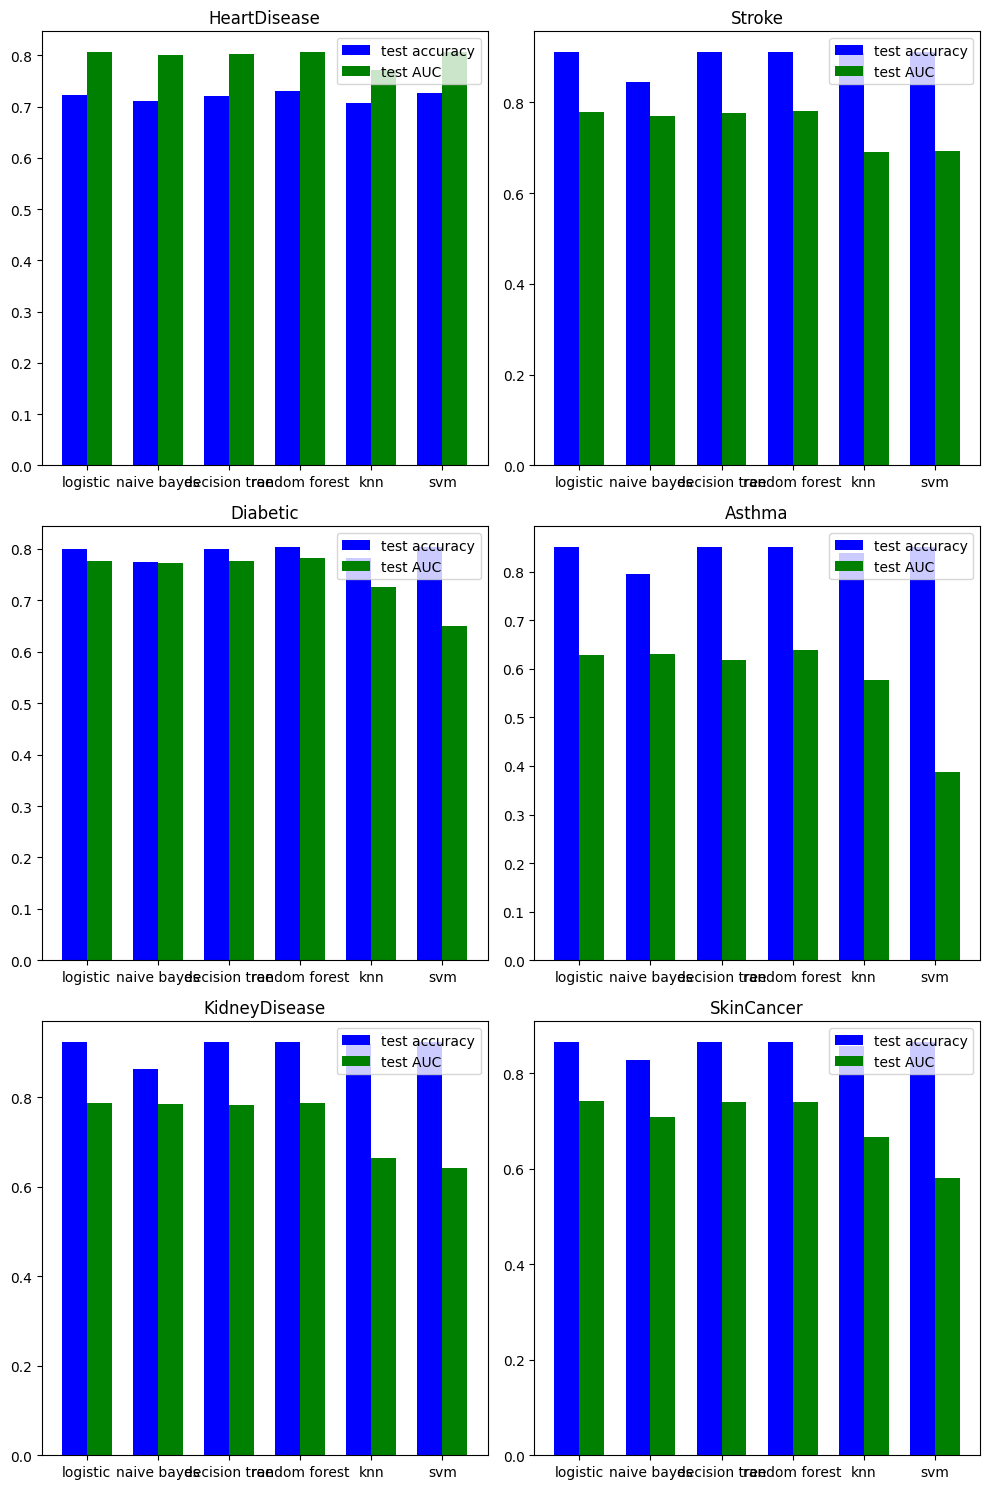

best model for HeartDisease based on test accuracy = random forest
model test accuracy = 72.98%
test accuracy via AUC = 80.63%
----------------------------------------------------------------------
best model for Stroke based on test accuracy = decision tree
model test accuracy = 91.14%
test accuracy via AUC = 77.60%
----------------------------------------------------------------------
best model for Diabetic based on test accuracy = random forest
model test accuracy = 80.39%
test accuracy via AUC = 78.31%
----------------------------------------------------------------------
best model for Asthma based on test accuracy = random forest
model test accuracy = 85.08%
test accuracy via AUC = 63.88%
----------------------------------------------------------------------
best model for KidneyDisease based on test accuracy = logistic
model test accuracy = 92.41%
test accuracy via AUC = 78.81%
----------------------------------------------------------------------
best model for SkinCancer base

In [12]:
results = {'logistic': resultLog, 'naive bayes': resultNaive, 'decision tree': resultDes, 'random forest': resultRandom, 'knn': resultknn, 'svm': resultsvm}
target = ['HeartDisease', 'Stroke', 'Diabetic', 'Asthma', 'KidneyDisease', 'SkinCancer']
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
axes = axes.ravel()
barWidth = 0.35
index = np.arange(len(results))

for idx, disease in enumerate(target):
    testAcc = []
    testauc = []
    for model in results:
        testAcc.append(results[model][disease]['test accuracy'])
        testauc.append(results[model][disease]['test auc'])
    
    axes[idx].bar(index, testAcc, barWidth, label='test accuracy', color='b')
    axes[idx].bar(index + barWidth, testauc, barWidth, label='test AUC', color='g')
    axes[idx].set_title(disease)
    axes[idx].set_xticks(index + barWidth / 2)
    axes[idx].set_xticklabels(list(results.keys()))
    axes[idx].legend()

plt.tight_layout()
plt.show()

best = {}
for disease in target:
    besttest = None
    testacc = -1
    bestauc = -1
    for model in results:
        testAcc = results[model][disease]['test accuracy']
        testauc = results[model][disease]['test auc']
        if testAcc > testacc:
            testacc = testAcc
            bestauc = testauc
            besttest = model
    
    best[disease] = besttest

for disease in target:
    besttest = best[disease]
    bestauc = results[besttest][disease]['test auc']
    print(f"best model for {disease} based on test accuracy = {besttest}")
    print(f"model test accuracy = {results[besttest][disease]['test accuracy']*100:.2f}%")
    print(f"test accuracy via AUC = {100 * bestauc:.2f}%")
    print("-" * 70)